## Related Article
This notebook contains all simulations and analysis supporting the article: **[Estimating OPL and power curves from limited data](https://www.caiopimentel.com/data-blog/estimating-opl-and-power-curves-from-limited-data)**  

Please refer to the article for context, interpretations, and practical recommendations.

## Setup

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# import statsmodels.api as sm
from scipy import stats
from scipy.stats import halfnorm, ttest_rel,wilcoxon
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
sns.set_theme()
%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi'] = 120

rng = np.random.default_rng()

## Functions

In [3]:
def simulate_power_test(load_interval: list, velocity_interval: list, add_error=True, error_scale=0.08, n=5):

    load = np.linspace(load_interval[0], load_interval[1], n)
    velocity = np.linspace(velocity_interval[0], velocity_interval[1], n)

    fatigue_start = 0       # In which set fatigue starts settling in and affecting subsequent sets
    fatigue = np.ones(n)

    if add_error:
        # Random error
        error = - halfnorm.rvs(loc = 0, scale = error_scale, size=n, random_state=rng)     
        # Error don't differ base on load (as can be the case in real life for loads with less coordination)

        # Systematic error
        for i, _ in enumerate(load):
            if i > fatigue_start:
                fatigue[i] = np.clip(1 - (i*0.04), 0, 1)     # Session fatigue here is not being affected by load, RIR or rest time
        
        velocity = (velocity * fatigue) + error

    power = velocity * load * 9.81

    sim_df = pd.DataFrame()
    sim_df['load'] = load
    sim_df['velocity'] = velocity
    sim_df['power'] = power
    sim_df['fatigue'] = fatigue
    
    return(sim_df)

In [4]:
def fit_lin(velocity: list, load: list):
    slope, intercept, r, *_ = stats.linregress(load, velocity)   
    # velocity = slope * load + intercept

    return(slope, intercept, r)


def estimate_power_lin(lin_coef, load: list):
    
    slope, intercept, _ = lin_coef  # linear coefficients
    estimate_velocity = lambda load: slope * load + intercept

    df = pd.DataFrame()
    df['load'] = load
    df['velocity'] = estimate_velocity(df['load'])
    df['power'] = df['load'] * df['velocity'] * 9.81
    df['source'] = 'theoretical'

    return(df)

In [5]:
def fit_poly(load: list, power: list):
    coefficients = np.polyfit(load, power, 2)
    poly_func = np.poly1d(coefficients)

    return(poly_func)

def estimate_power_poly(poly_func, load_grid):
    df = pd.DataFrame()
    df['load'] = load_grid
    df['power'] = poly_func(df['load'])

    return(df)

## Single trial simulation

### Simulation

In [6]:
# Line endpoints coordinates for the relationship between load and velocity (eg. 160 is the 1RM load and 0.22m/s the velocity at failure)
load_coordinates = [0, 160]   # x coordinates
vel_coordinates = [2.7, 0.22]     # y coordinates

In [7]:
## Simulate perfect data collection with no error or fatigue interference 
sim_df_pure = simulate_power_test(load_interval=load_coordinates, velocity_interval=vel_coordinates, add_error=False, n=50)

Simulate real life **data collection**

In [8]:
# Selecting load range that will be tested
row_lower_bound = int(len(sim_df_pure)*0.5)     # Row of approximately the 45th percentile
row_upper_bound = int(len(sim_df_pure)*0.90)     # Row of approximately the 90th percentile

load_range = [sim_df_pure['load'][row_lower_bound], sim_df_pure['load'][row_upper_bound]]
velocity_range = [sim_df_pure['velocity'][row_lower_bound], sim_df_pure['velocity'][row_upper_bound]]

sim_df_error = simulate_power_test(load_interval=load_range, velocity_interval=velocity_range, add_error=True, error_scale=0.08, n=5)     # Including error

### Estimations

In [9]:
eval_min_load = 40
eval_interval_pure = sim_df_pure[sim_df_pure['load'] > eval_min_load]
eval_load_grid = eval_interval_pure['load']
eval_power_pure = eval_interval_pure['power']

#### Linear model

In [10]:
l_fit = fit_lin(sim_df_error['velocity'], sim_df_error['load'])
lin_df = estimate_power_lin(l_fit, eval_load_grid)
l_r = l_fit[-1]

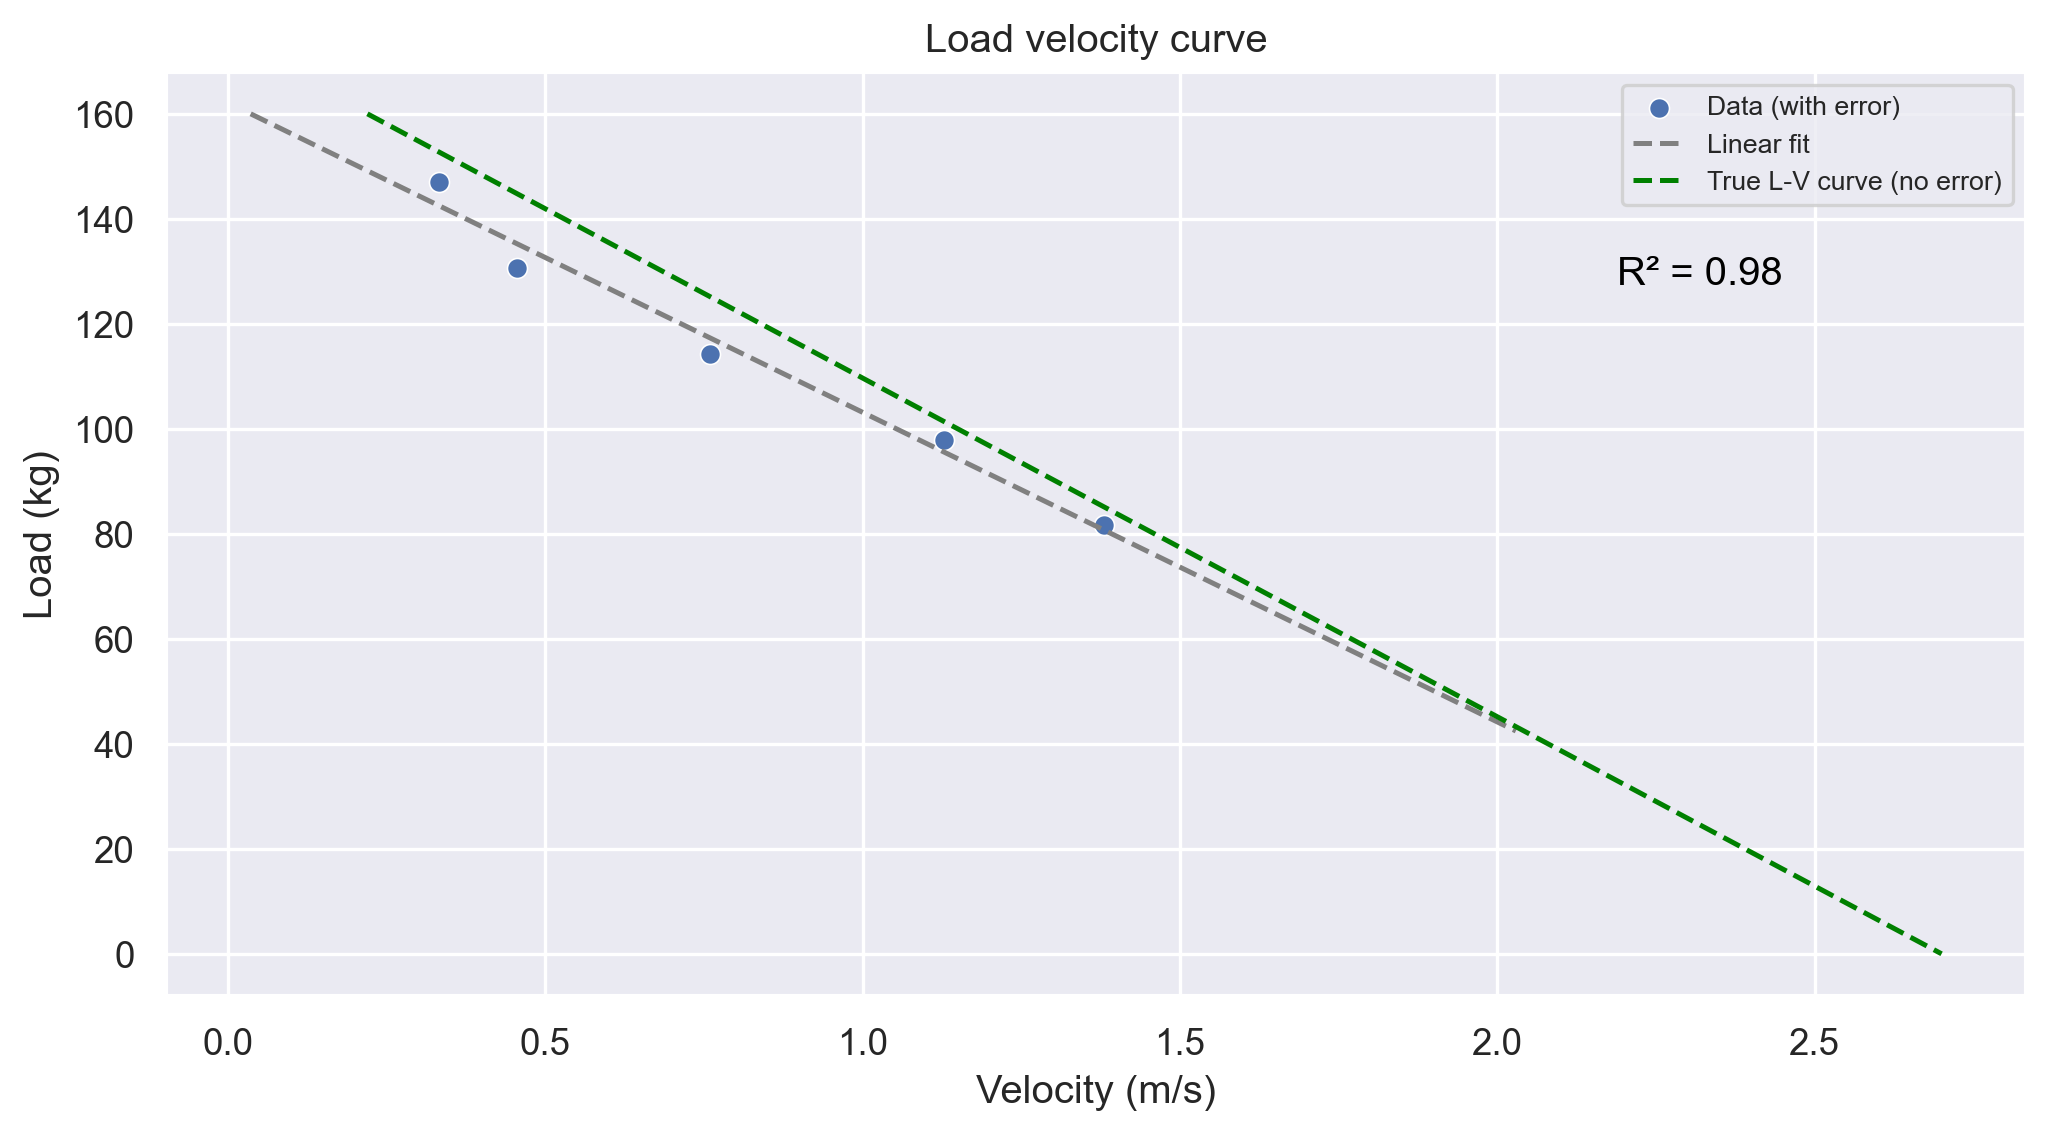

In [11]:
plt.figure(figsize=(10,5))

sns.scatterplot(data=sim_df_error, x='velocity', y='load', label='Data (with error)')
sns.lineplot(data=lin_df, x='velocity', y='load', linestyle='dashed', color='gray', label='Linear fit')
sns.lineplot(data=sim_df_pure, x='velocity', y='load', linestyle='dashed', color='green', label='True L-V curve (no error)')

plt.text(
    0.78, 0.80, 
    f"R² = {l_r**2:.2f}", 
    transform=plt.gca().transAxes,
    ha="left", va="top", fontsize=12, color="black"
)

plt.title("Load velocity curve")
plt.xlabel('Velocity (m/s)')
plt.ylabel('Load (kg)')
plt.legend(prop={'size': 8})
plt.show()


### Estimation based on polynomial fit on power vs load

In [12]:
p_fit = fit_poly(sim_df_error['load'], sim_df_error['power'])
poly_df = estimate_power_poly(p_fit, load_grid=eval_load_grid)

### Comparison of approaches

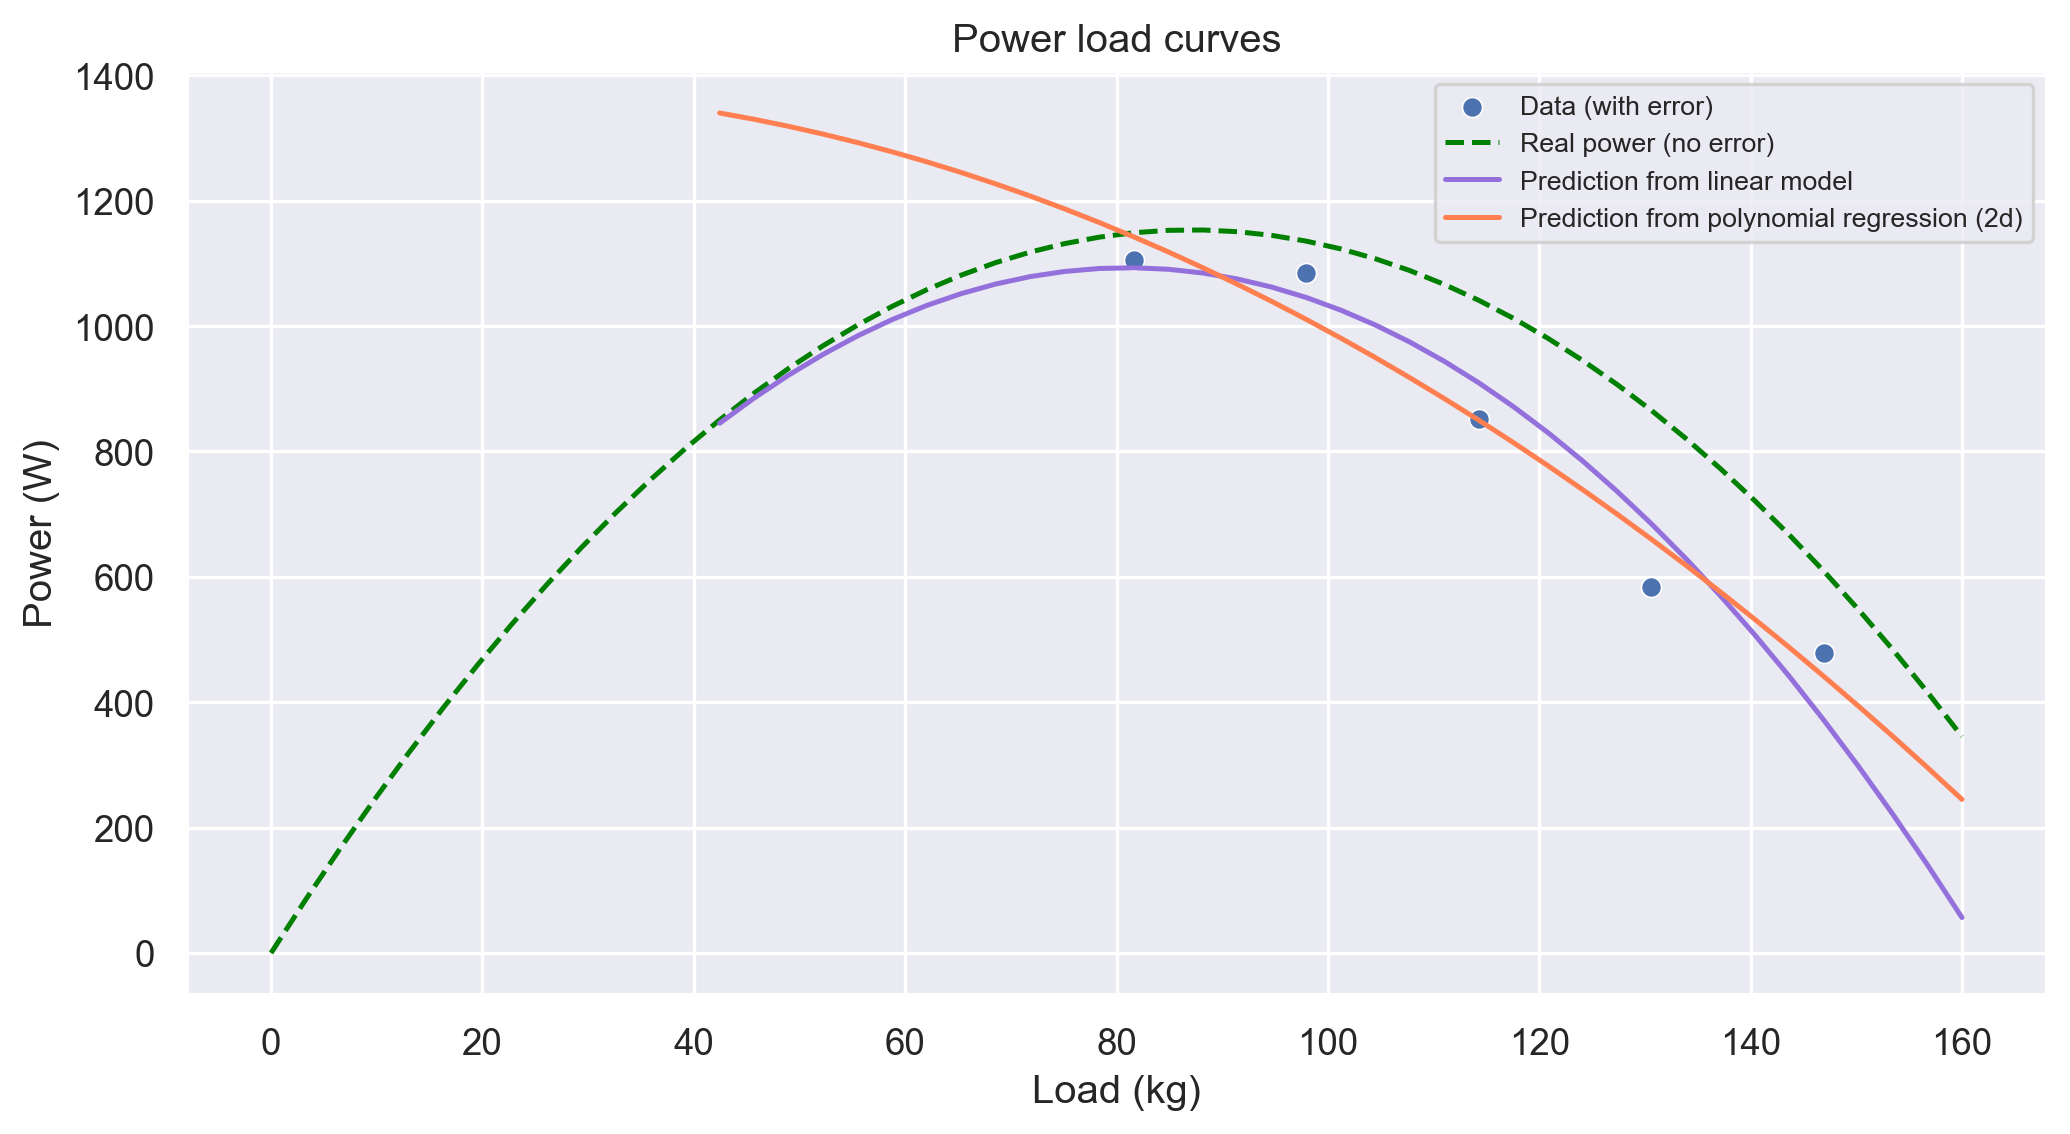

In [13]:
plt.figure(figsize=(10,5))

sns.scatterplot(data=sim_df_error, x='load', y='power', label='Data (with error)')
sns.lineplot(data=sim_df_pure, x='load', y='power', linestyle='dashed', color='green', label='Real power (no error)')

sns.lineplot(x=lin_df['load'], y=lin_df['power'], color='mediumpurple', label='Prediction from linear model')
sns.lineplot(x=poly_df['load'], y=poly_df['power'], color='coral', label='Prediction from polynomial regression (2d)')

plt.title("Power load curves")
plt.xlabel('Load (kg)')
plt.ylabel('Power (W)')
plt.legend(prop={'size': 8})
plt.show()


In [14]:
r2 = r2_score(eval_power_pure, lin_df['power'])
rmse = np.sqrt(mean_squared_error(eval_power_pure, lin_df['power']))

print("r2_linear:", r2)
print("rmse_linear:", rmse)

r2_poly = r2_score(eval_power_pure, poly_df['power'])
rmse_poly = np.sqrt(mean_squared_error(eval_power_pure, poly_df['power']))

print("r2_polynomial:", r2_poly)
print("rmse_polynomial:", rmse_poly)


r2_linear: 0.5868091644961055
rmse_linear: 143.3082150178156
r2_polynomial: 0.14726168416491237
rmse_polynomial: 205.87501090999737


## Large sample simulation and analysis

### Setup

In [15]:
## Simulate perfect data collection with no error or fatigue interference 
sim_df_pure = simulate_power_test(load_interval=[0, 160], velocity_interval=[2.7, 0.22], add_error=False, n=50)

eval_min_load = 0
eval_interval_pure = sim_df_pure[sim_df_pure['load'] > eval_min_load]
eval_load_grid = eval_interval_pure['load']
eval_power_pure = eval_interval_pure['power']

In [16]:
true_opl_idx = sim_df_pure['power'].idxmax()
true_opl_load = sim_df_pure.loc[true_opl_idx, 'load']

In [17]:
sim_data = []

# Linear
sim_est_lin = []
sim_err_lin = []
sim_rmse_lin = []
sim_opl_lin = []

# Poly
sim_est_poly = []
sim_err_poly = []
sim_rmse_poly = []
sim_opl_poly = []


In [18]:
# Selecting load range that will be tested
row_lower_bound = int(len(sim_df_pure)*0.45)     # Row of approximately the 45th percentile
row_upper_bound = int(len(sim_df_pure)*0.90)     # Row of approximately the 90th percentile

load_range = [sim_df_pure['load'][row_lower_bound], sim_df_pure['load'][row_upper_bound]]
velocity_range = [sim_df_pure['velocity'][row_lower_bound], sim_df_pure['velocity'][row_upper_bound]]

### Large simulation

In [19]:
# Number of collection and estimation simulations
n_sim = 1000

for i in range(n_sim):
    sim_df_error = simulate_power_test(load_interval=load_range, velocity_interval=velocity_range, add_error=True, error_scale=0.08, n=5)     # Including error
    sim_data.append(sim_df_error)

    ### Linear
    l_fit = fit_lin(sim_df_error['velocity'], sim_df_error['load'])
    lin_df = estimate_power_lin(l_fit, eval_load_grid)
    sim_est_lin.append(lin_df)

    sim_err_lin.append(r2_score(eval_power_pure, lin_df['power']))  # Overall linear fit
    sim_rmse_lin.append(np.sqrt(mean_squared_error(eval_power_pure, lin_df['power'])))

    lin_opl_idx = lin_df['power'].idxmax()
    lin_opl_load = lin_df.loc[lin_opl_idx, 'load']
    sim_opl_lin.append(lin_opl_load)    # OLP estimation from linear model

    # Poly
    p_fit = fit_poly(sim_df_error['load'], sim_df_error['power'])
    poly_df = estimate_power_poly(p_fit, load_grid=eval_load_grid)
    sim_est_poly.append(poly_df)

    sim_err_poly.append(r2_score(eval_power_pure, poly_df['power']))  # Overall poly fit
    sim_rmse_poly.append(np.sqrt(mean_squared_error(eval_power_pure, poly_df['power'])))

    poly_opl_idx = poly_df['power'].idxmax()
    poly_opl_load = poly_df.loc[poly_opl_idx, 'load']
    sim_opl_poly.append(poly_opl_load)  # OLP estimation from poly model


#### Comparing OPL load estimation error

In [20]:
opl_true = np.array([true_opl_load] * n_sim)
opl_lin = np.array(sim_opl_lin)
opl_poly = np.array(sim_opl_poly)

opl_err_lin = np.abs(opl_lin - opl_true)
opl_err_poly = np.abs(opl_poly - opl_true)

opl_err_df = pd.DataFrame()
opl_err_df['error'] = np.concatenate((opl_err_lin, opl_err_poly))
opl_err_df['type'] = ['linear'] * n_sim + ['poly'] * n_sim

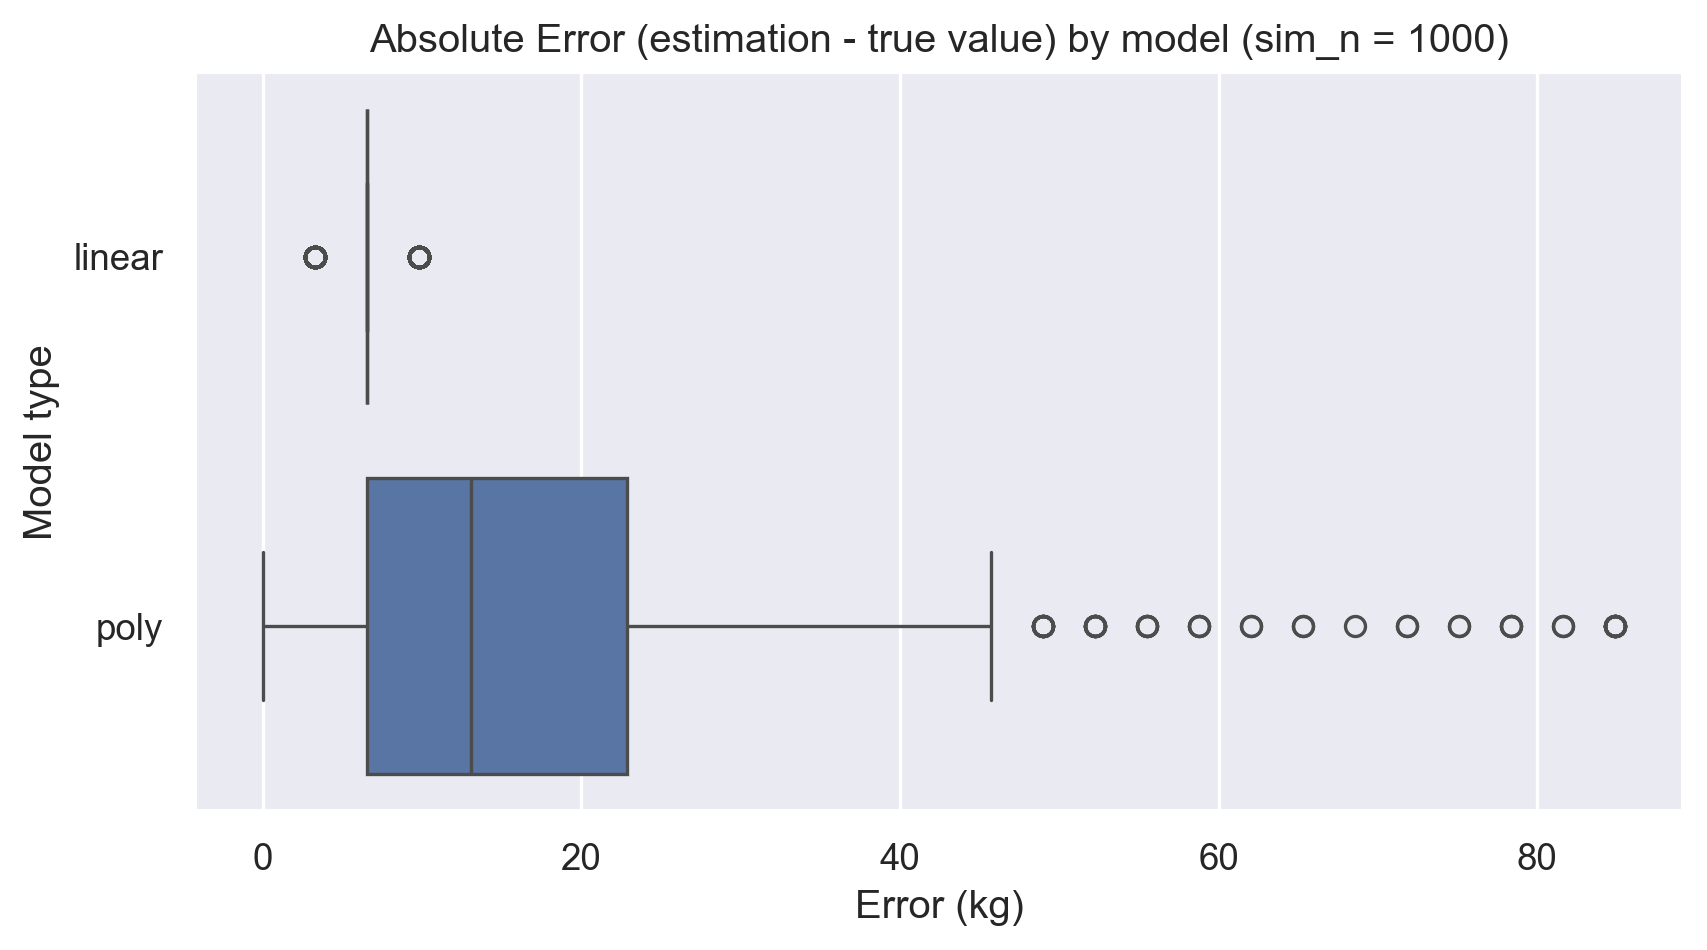

In [21]:
plt.figure(figsize=(8,4))

sns.boxplot(data=opl_err_df, x="error", y='type')

plt.xlabel('Error (kg)')
plt.ylabel('Model type')
plt.title(f"Absolute Error (estimation - true value) by model (sim_n = {n_sim})")
plt.show()

In [22]:
diff = opl_err_lin - opl_err_poly

mean_diff = diff.mean()
median_diff = np.median(diff)

print("OPL abs error (lin - poly):")
print("Mean diff:", mean_diff)
print("Median diff:", median_diff)

# non-parametric paired test
stat, p_value = wilcoxon(opl_err_lin, opl_err_poly)
print("Wilcoxon signed-rank stat:", stat)
print("p-value:", p_value)
print("p < 0.05?", p_value < 0.05)

OPL abs error (lin - poly):
Mean diff: -11.085714285714282
Median diff: -6.530612244897952
Wilcoxon signed-rank stat: 22408.5
p-value: 1.1776082784661693e-112
p < 0.05? True


#### Visualization of estimations

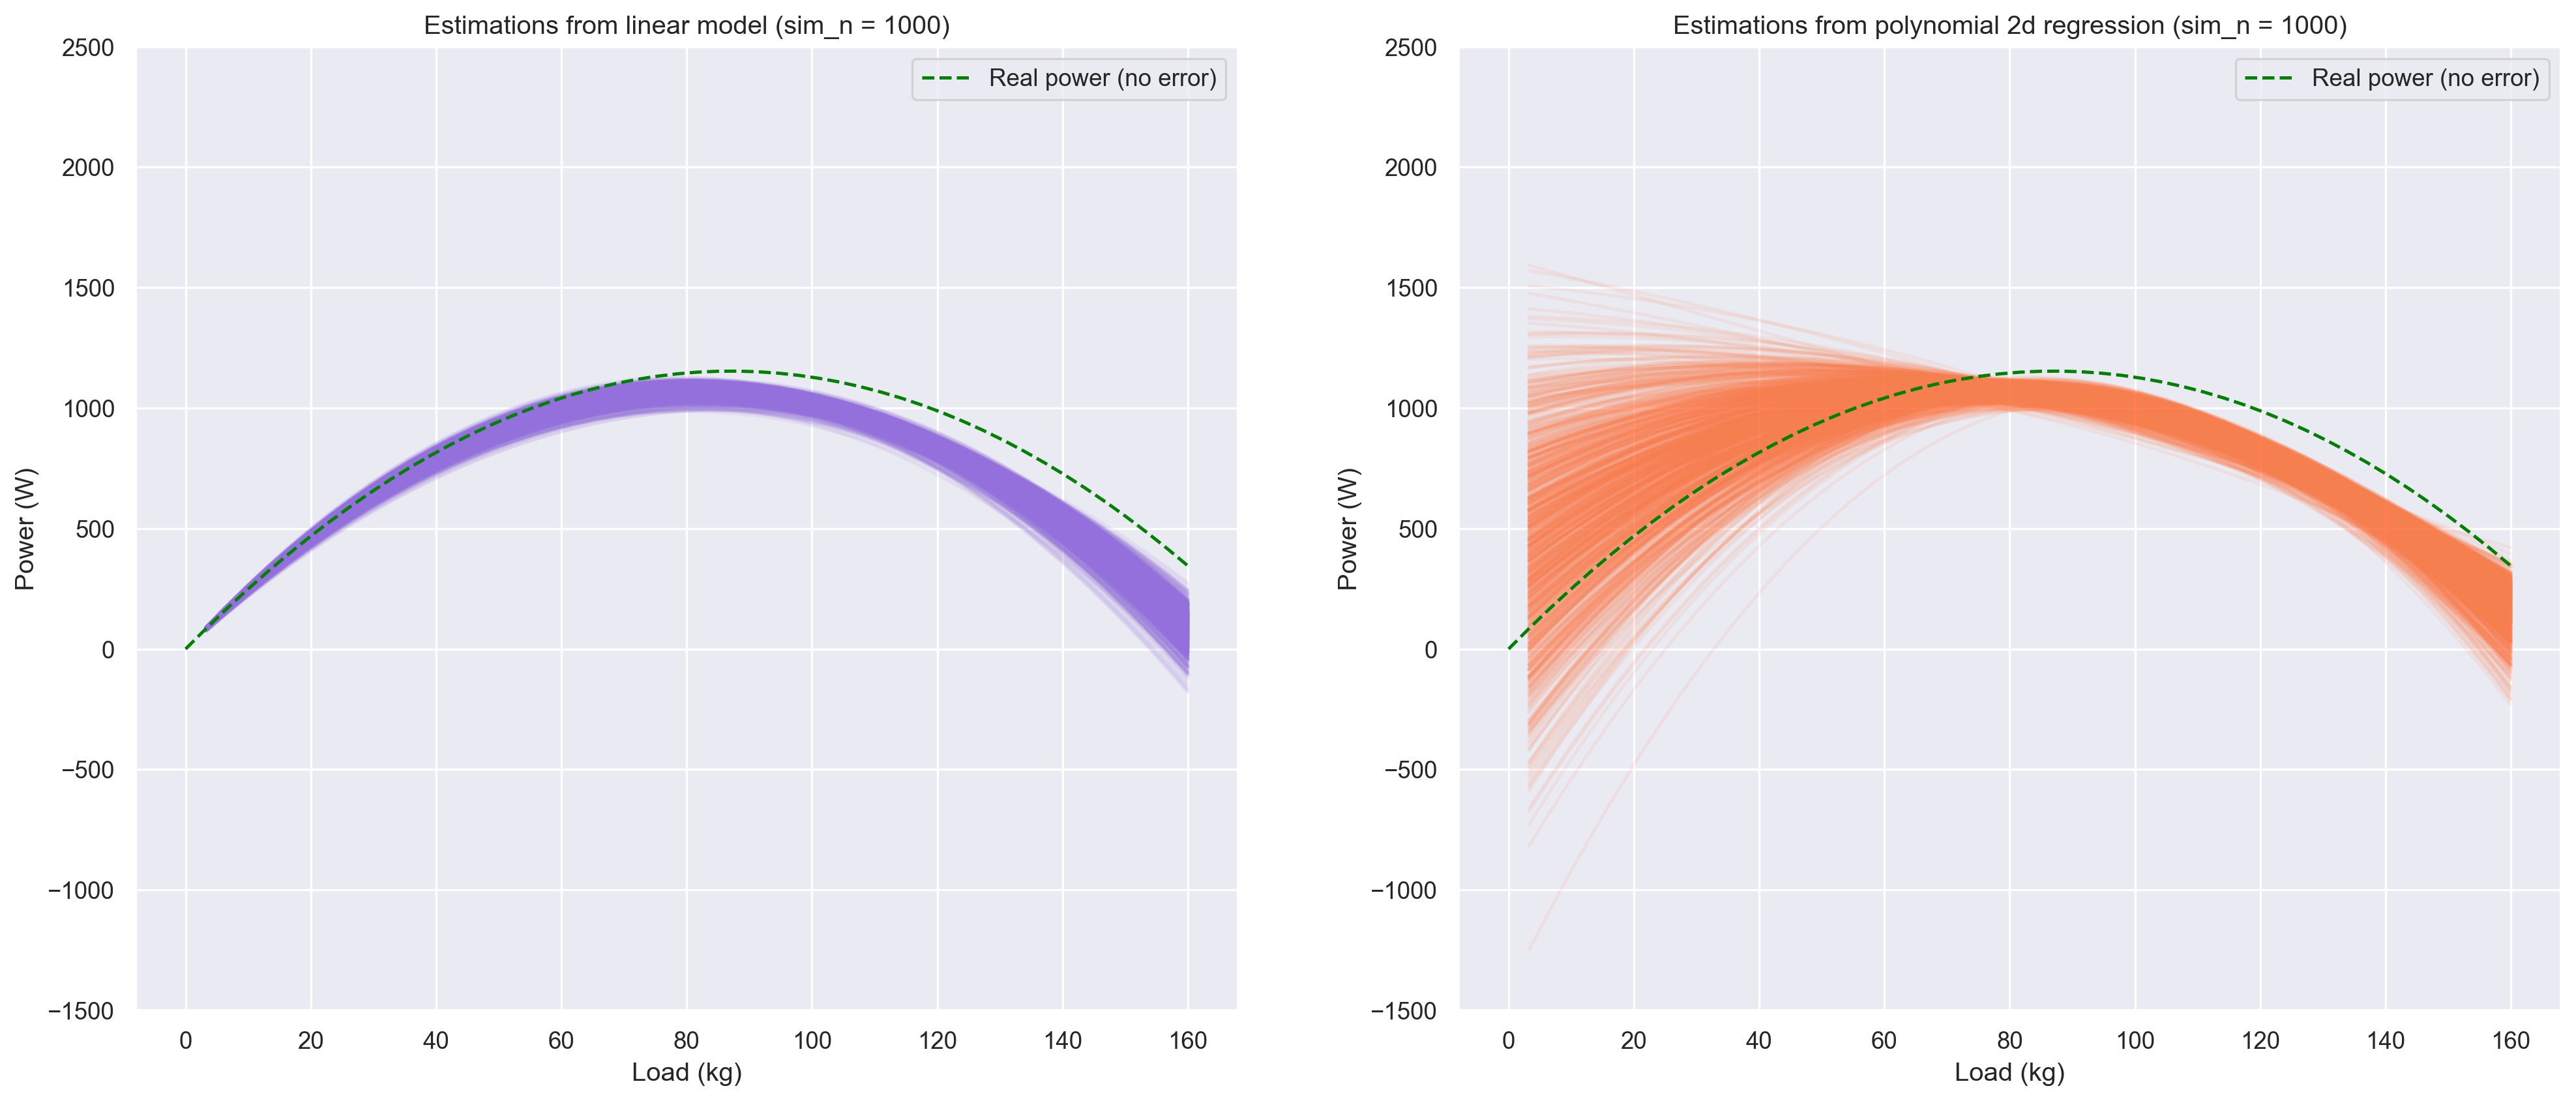

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

for i, d in enumerate(sim_est_lin):
    sns.lineplot(x=d['load'], y=d['power'], color='mediumpurple', alpha=0.1, ax=axs[0])

axs[0].set_title(f'Estimations from linear model (sim_n = {n_sim})')
axs[0].set_ylim(bottom=-1500, top=2500)
axs[0].set_xlabel('Load (kg)')
axs[0].set_ylabel('Power (W)')

for i, d in enumerate(sim_est_poly):
    sns.lineplot(x=d['load'], y=d['power'], color='coral', alpha=0.1, ax=axs[1])

axs[1].set_title(f'Estimations from polynomial 2d regression (sim_n = {n_sim})')
axs[1].set_ylim(bottom=-1500, top=2500)
axs[1].set_xlabel('Load (kg)')
axs[1].set_ylabel('Power (W)')

sns.lineplot(x=sim_df_pure['load'], y=sim_df_pure['power'], linestyle='dashed', color='green', label='Real power (no error)', ax=axs[0])
sns.lineplot(x=sim_df_pure['load'], y=sim_df_pure['power'], linestyle='dashed', color='green', label='Real power (no error)', ax=axs[1])

# plt.legend(prop={'size': 8})
plt.show()


### R2 analysis

#### Distributions

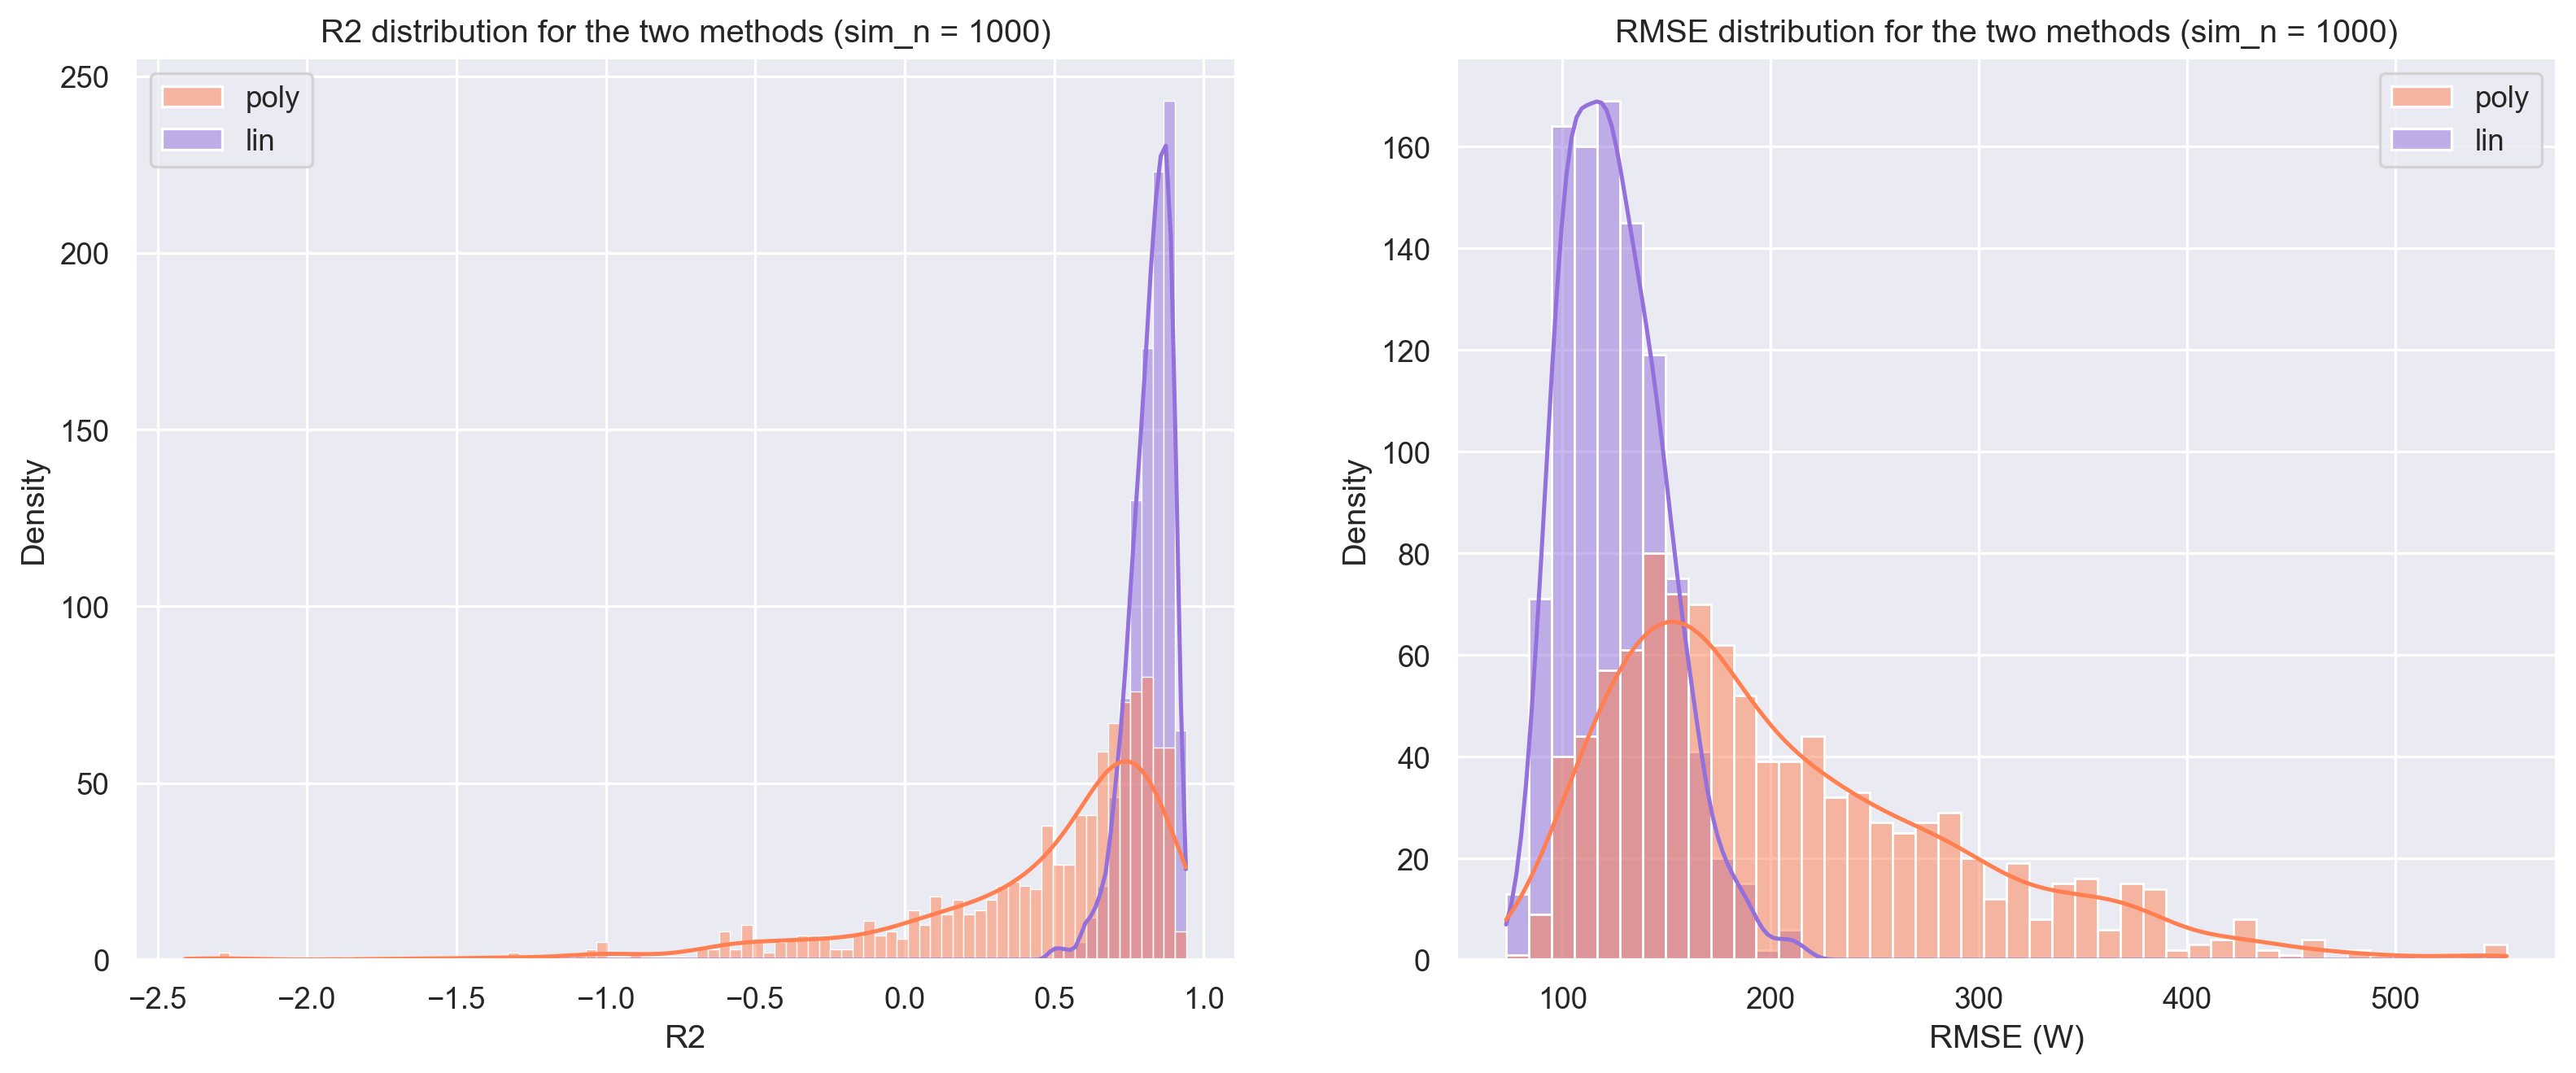

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=pd.DataFrame({'poly': sim_err_poly, 'lin': sim_err_lin}), palette={'lin': 'mediumpurple', 'poly': 'coral'}, kde=True, ax=axs[0])
axs[0].set_title(f'R2 distribution for the two methods (sim_n = {n_sim})')
axs[0].set_xlabel('R2')
axs[0].set_ylabel('Density')

sns.histplot(data=pd.DataFrame({'poly': sim_rmse_poly, 'lin': sim_rmse_lin}), palette={'lin': 'mediumpurple', 'poly': 'coral'}, kde=True, ax=axs[1])
axs[1].set_title(f'RMSE distribution for the two methods (sim_n = {n_sim})')
axs[1].set_xlabel('RMSE (W)')
axs[1].set_ylabel('Density')

plt.show()


In [25]:
r2_lin = np.array(sim_err_lin)
r2_poly = np.array(sim_err_poly)

rmse_lin = np.array(sim_rmse_lin)
rmse_poly = np.array(sim_rmse_poly)

for metric_name, lin_vals, poly_vals in [('R2', r2_lin, r2_poly), ('RMSE', rmse_lin, rmse_poly)]:
    diff = lin_vals - poly_vals

    mean_diff = diff.mean()
    std_diff = diff.std()

    print(f"{metric_name} mean difference (lin - poly):", mean_diff)
    print(f"{metric_name} std of differences:", std_diff)

    # non-parametric paired test
    stat, p_wilcoxon = wilcoxon(lin_vals, poly_vals)
    print(f"{metric_name} wilcoxon signed-rank: stat={stat:.3f}, p={p_wilcoxon}")
    print(f"{metric_name} p-value < 0.05? ", p_wilcoxon < 0.05)
    print()

R2 mean difference (lin - poly): 0.3732307396094178
R2 std of differences: 0.4688926200252626
R2 wilcoxon signed-rank: stat=2841.000, p=1.6050584207759226e-161
R2 p-value < 0.05?  True

RMSE mean difference (lin - poly): -81.51241032965592
RMSE std of differences: 78.75498006676759
RMSE wilcoxon signed-rank: stat=2750.000, p=1.225045456359868e-161
RMSE p-value < 0.05?  True



#### Analysing change of R2 of methods as error increases

In [26]:
## Simulate perfect data collection with no error or fatigue interference 
sim_df_pure = simulate_power_test(load_interval=[0, 160], velocity_interval=[2.7, 0.22], add_error=False, n=50)

eval_min_load = 20
eval_interval_pure = sim_df_pure[sim_df_pure['load'] > eval_min_load]
eval_load_grid = eval_interval_pure['load']
eval_power_pure = eval_interval_pure['power']

In [27]:
sim_data = []

# Linear
sim_est_lin = []
sim_err_lin = []
sim_opl_lin = []

# Poly
sim_est_poly = []
sim_err_poly = []
sim_opl_poly = []

In [28]:
# Selecting load range that will be tested
row_lower_bound = int(len(sim_df_pure)*0.45)     # Row of approximately the 45th percentile
row_upper_bound = int(len(sim_df_pure)*0.90)     # Row of approximately the 90th percentile

load_range = [sim_df_pure['load'][row_lower_bound], sim_df_pure['load'][row_upper_bound]]
velocity_range = [sim_df_pure['velocity'][row_lower_bound], sim_df_pure['velocity'][row_upper_bound]]

In [29]:
n_sim = 1000

err_range = np.linspace(0.02, 0.25, 20)

r2_df = pd.DataFrame(columns=['source', 'mean', 'median', 'std', 'error_scale'])
rmse_df = pd.DataFrame(columns=['source', 'mean', 'median', 'std', 'error_scale'])

for e in err_range:

    sim_err_lin = []
    sim_err_poly = []
    sim_rmse_lin = []
    sim_rmse_poly = []

    for i in range(n_sim):
        sim_df_error = simulate_power_test(load_range, velocity_range, add_error=True, error_scale=e, n=5)

        l_fit = fit_lin(sim_df_error['velocity'], sim_df_error['load'])
        lin_df = estimate_power_lin(l_fit, eval_load_grid)
        sim_err_lin.append(r2_score(eval_power_pure, lin_df['power']))
        sim_rmse_lin.append(np.sqrt(mean_squared_error(eval_power_pure, lin_df['power'])))

        p_fit = fit_poly(sim_df_error['load'], sim_df_error['power'])
        poly_df = estimate_power_poly(p_fit, load_grid=eval_load_grid)
        sim_err_poly.append(r2_score(eval_power_pure, poly_df['power']))
        sim_rmse_poly.append(np.sqrt(mean_squared_error(eval_power_pure, poly_df['power'])))

    r2_df.loc[len(r2_df)] = ['lin', np.mean(sim_err_lin), np.median(sim_err_lin), np.std(sim_err_lin), e]
    r2_df.loc[len(r2_df)] = ['poly', np.mean(sim_err_poly), np.median(sim_err_poly), np.std(sim_err_poly), e]

    rmse_df.loc[len(rmse_df)] = ['lin', np.mean(sim_rmse_lin), np.median(sim_rmse_lin), np.std(sim_rmse_lin), e]
    rmse_df.loc[len(rmse_df)] = ['poly', np.mean(sim_rmse_poly), np.median(sim_rmse_poly), np.std(sim_rmse_poly), e]



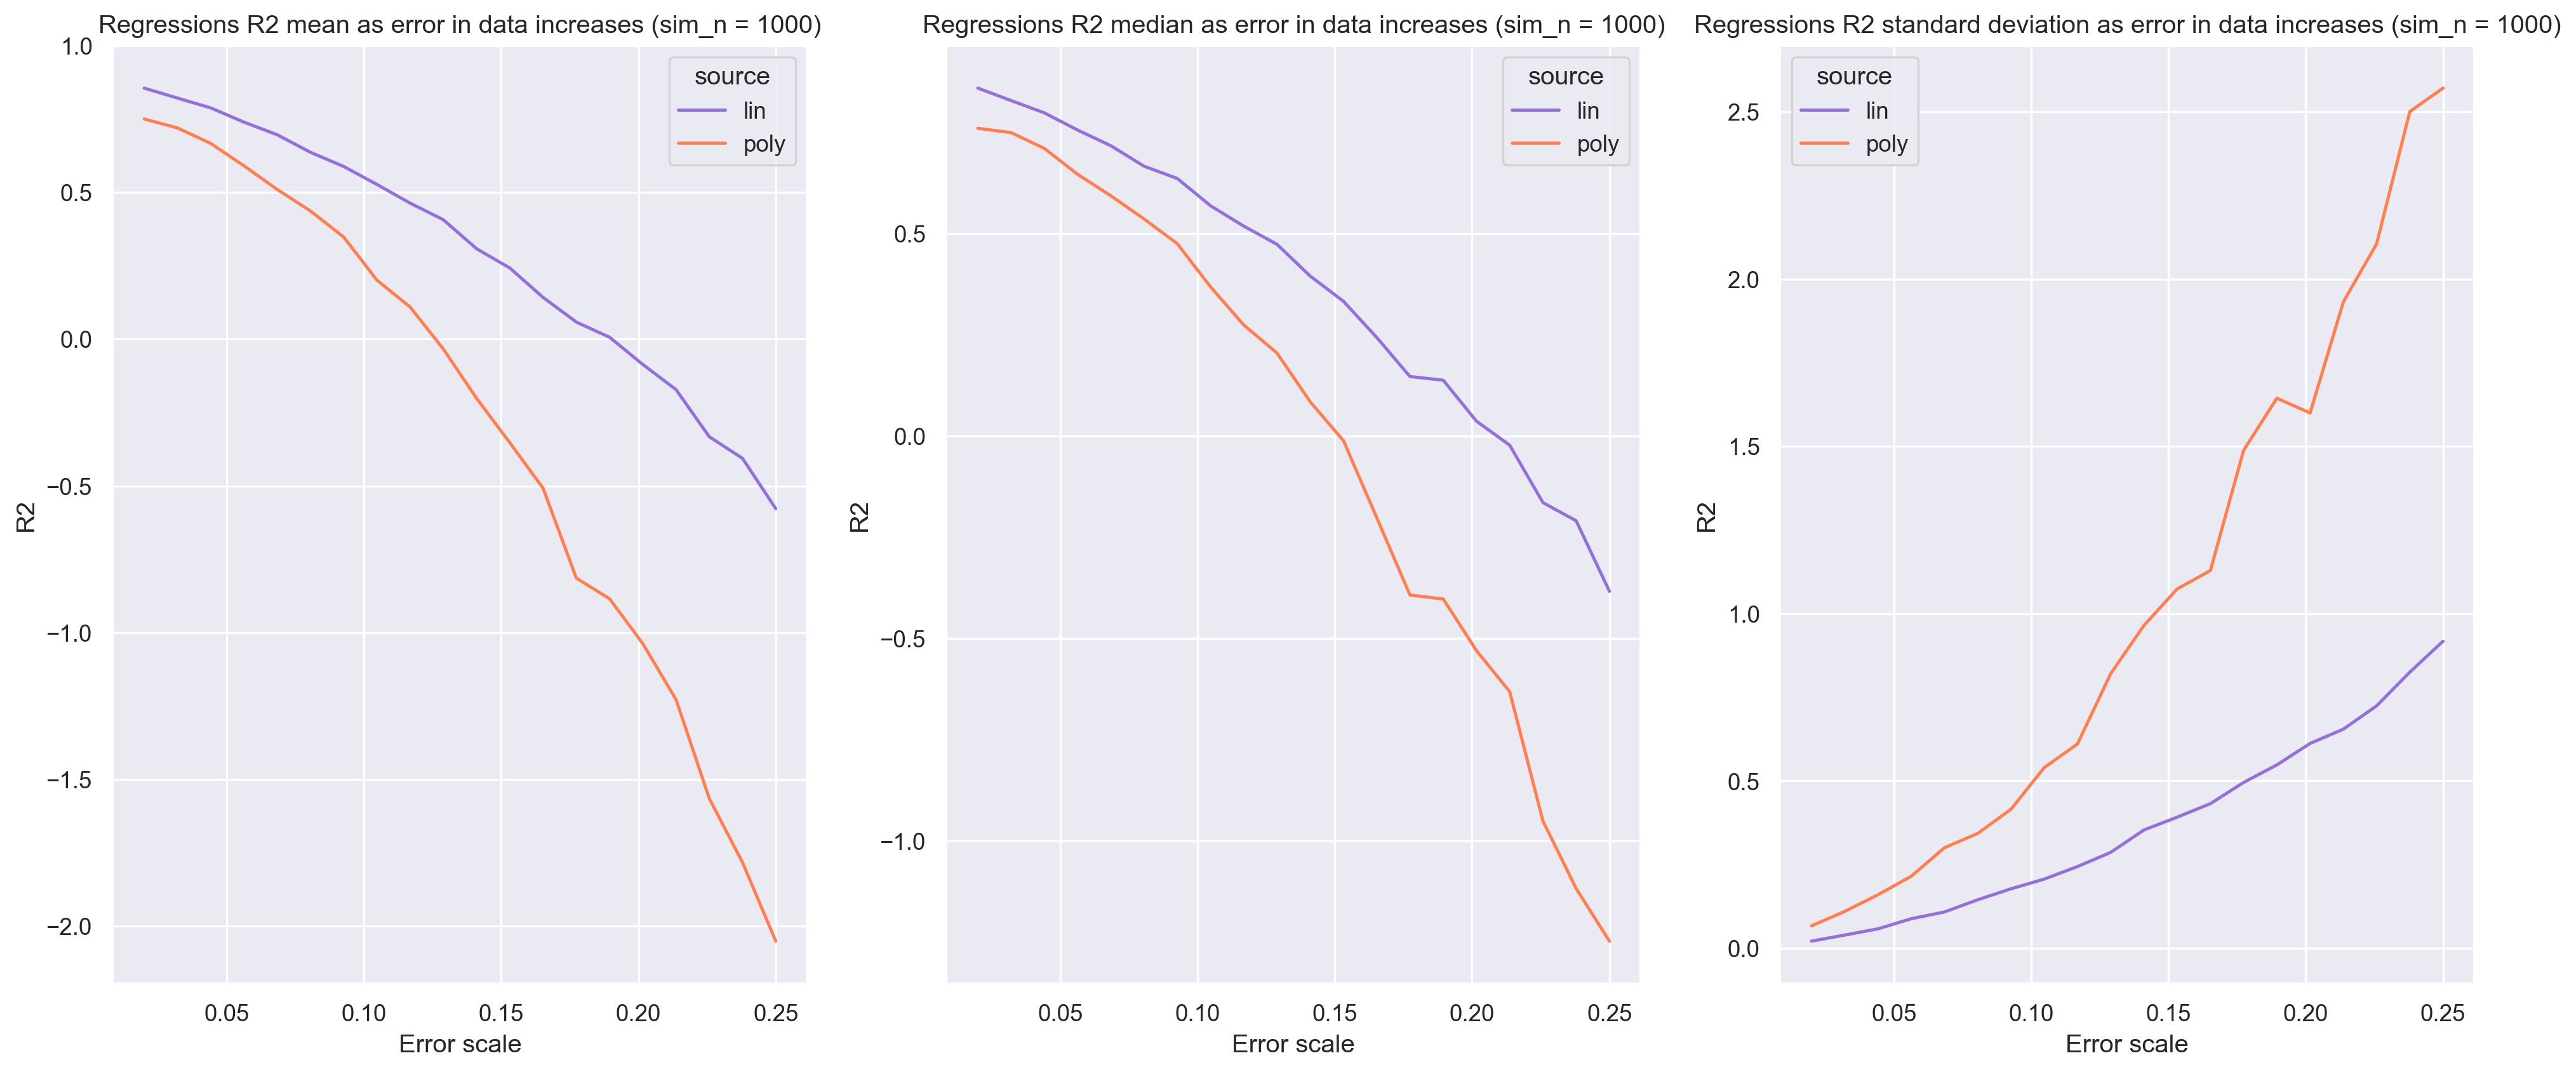

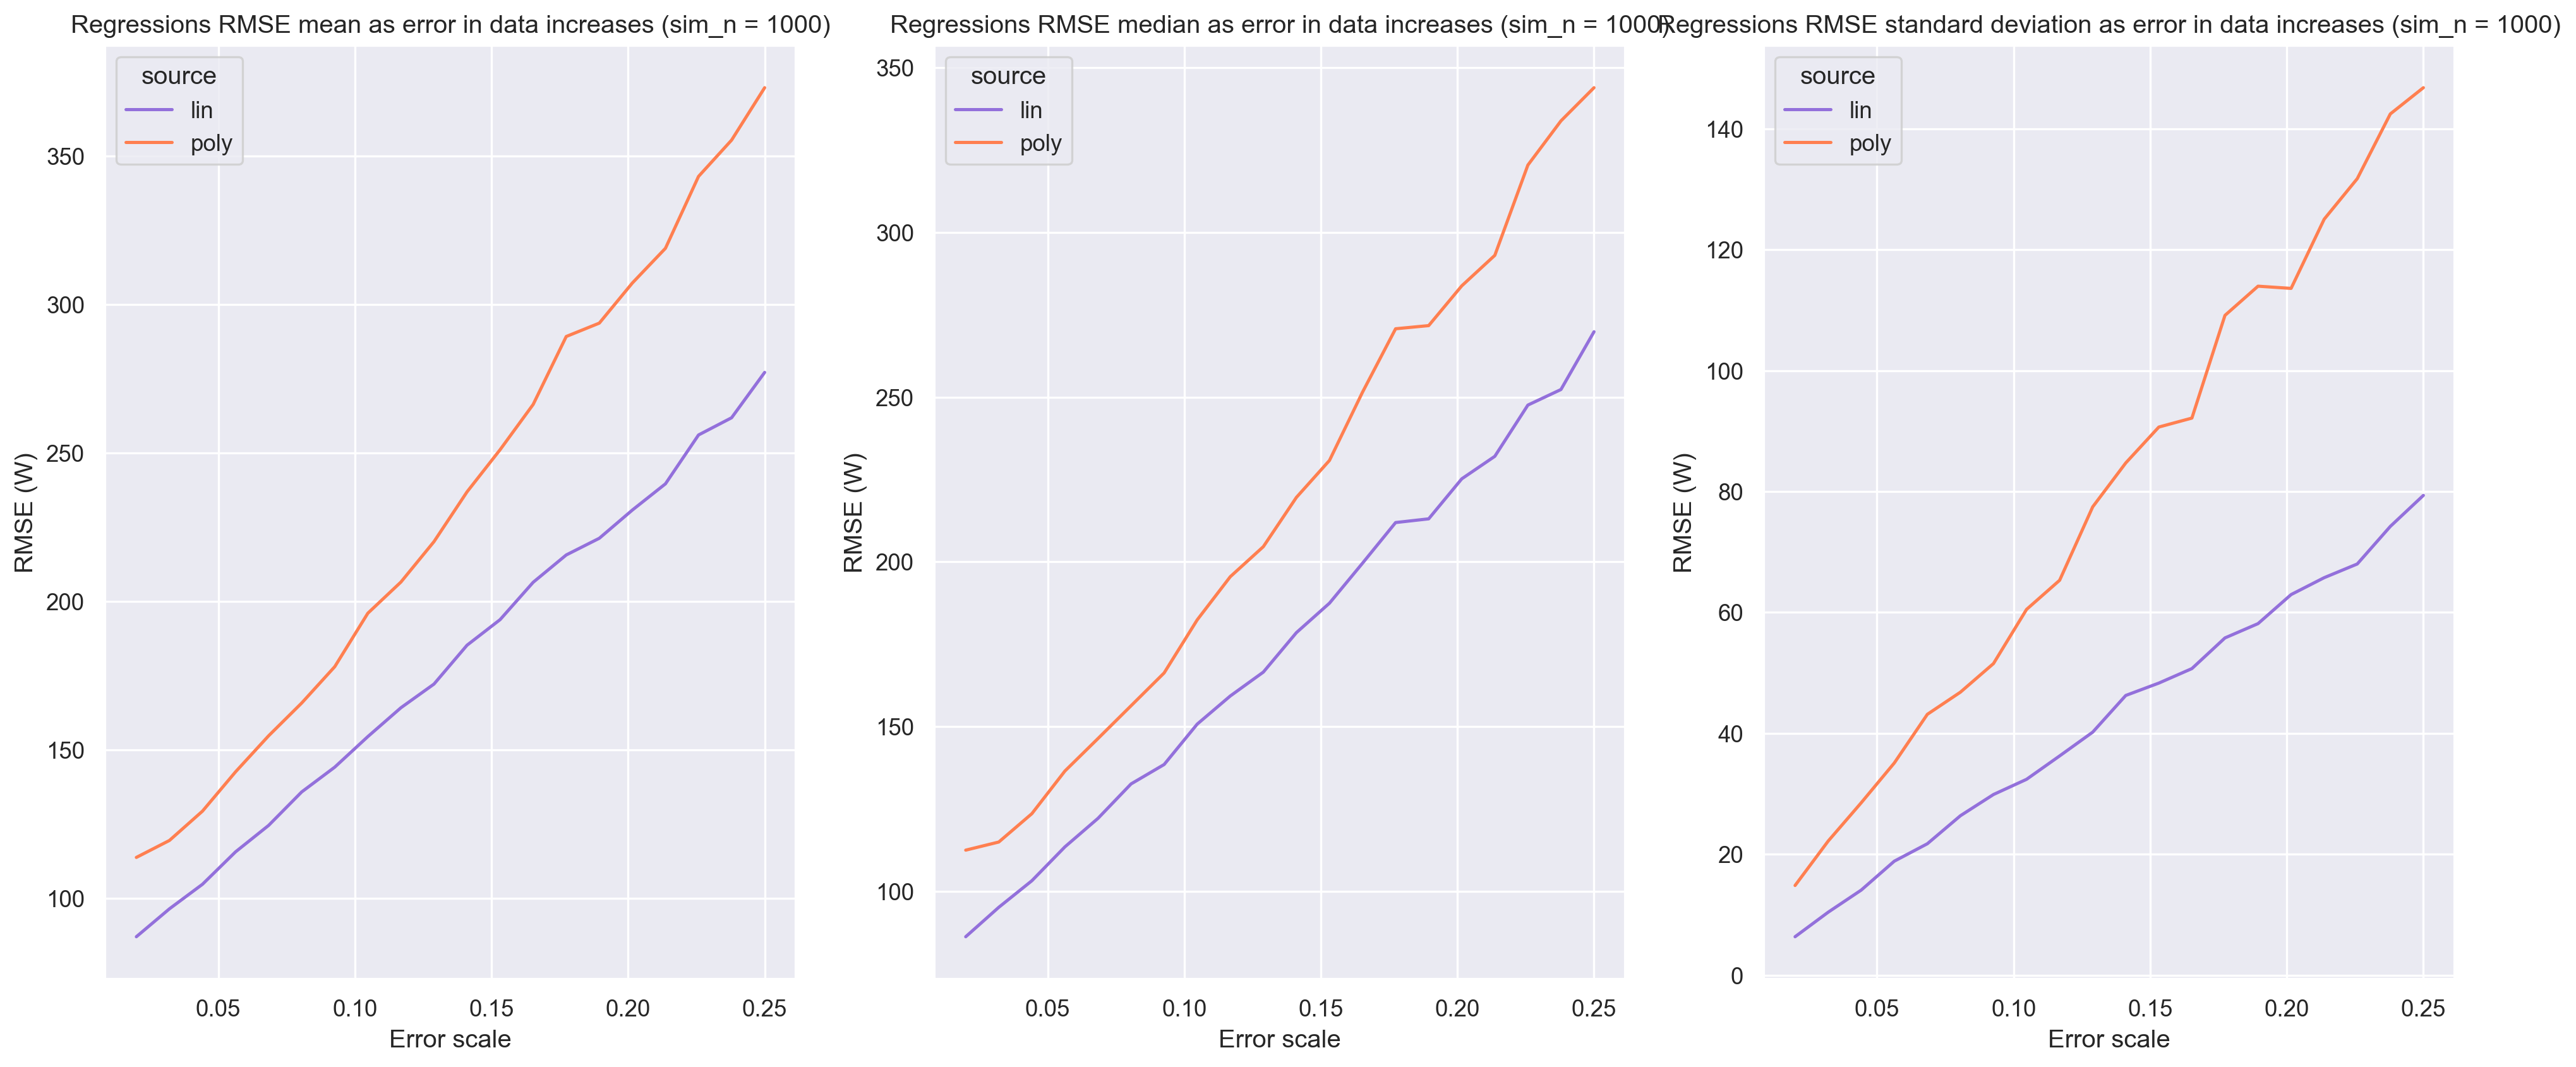

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

sns.lineplot(data=r2_df, x='error_scale', y='mean', hue='source', ax=axs[0], palette={'lin': 'mediumpurple', 'poly': 'coral'})
sns.lineplot(data=r2_df, x='error_scale', y='median', hue='source', ax=axs[1], palette={'lin': 'mediumpurple', 'poly': 'coral'})
sns.lineplot(data=r2_df, x='error_scale', y='std', hue='source', ax=axs[2], palette={'lin': 'mediumpurple', 'poly': 'coral'})

axs[0].set_title(f'Regressions R2 mean as error in data increases (sim_n = {n_sim})')
axs[1].set_title(f'Regressions R2 median as error in data increases (sim_n = {n_sim})')
axs[2].set_title(f'Regressions R2 standard deviation as error in data increases (sim_n = {n_sim})')

axs[0].set_xlabel('Error scale')
axs[1].set_xlabel('Error scale')
axs[2].set_xlabel('Error scale')
axs[0].set_ylabel('R2')
axs[1].set_ylabel('R2')
axs[2].set_ylabel('R2')

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

sns.lineplot(data=rmse_df, x='error_scale', y='mean', hue='source', ax=axs[0], palette={'lin': 'mediumpurple', 'poly': 'coral'})
sns.lineplot(data=rmse_df, x='error_scale', y='median', hue='source', ax=axs[1], palette={'lin': 'mediumpurple', 'poly': 'coral'})
sns.lineplot(data=rmse_df, x='error_scale', y='std', hue='source', ax=axs[2], palette={'lin': 'mediumpurple', 'poly': 'coral'})

axs[0].set_title(f'Regressions RMSE mean as error in data increases (sim_n = {n_sim})')
axs[1].set_title(f'Regressions RMSE median as error in data increases (sim_n = {n_sim})')
axs[2].set_title(f'Regressions RMSE standard deviation as error in data increases (sim_n = {n_sim})')

axs[0].set_xlabel('Error scale')
axs[1].set_xlabel('Error scale')
axs[2].set_xlabel('Error scale')
axs[0].set_ylabel('RMSE (W)')
axs[1].set_ylabel('RMSE (W)')
axs[2].set_ylabel('RMSE (W)')

plt.show()
